# Preparing data for linear regression - with some feature engineering

In [1]:
#import data_utils as du

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from data_utils import replace_boolean_values
from data_utils import create_dummy_df
from data_utils import convert_strings_to_columns

In [2]:
LOCATION = 'munich'

df_lst = pd.read_csv(LOCATION + '/listings.csv.gz')

In [3]:
pd.options.display.max_rows=100
pd.options.display.max_columns=None
pd.options.display.max_colwidth=30

---

### Let's apply all data preparations from previous notebook (4. Prepare data.ipynb)

In [4]:
# Drop columns with all missing values
drop_me = df_lst.columns[df_lst.isnull().all()]
df_lst.drop(columns=drop_me, axis=1, inplace=True)

# Set proper data types for numerical values
df_lst.price=df_lst.price.replace(to_replace='[\$,]', value='', regex=True).astype(float)
df_lst.host_response_rate = df_lst.host_response_rate.replace(to_replace='[\%,]', value='', regex=True).astype(float)/100
df_lst.host_acceptance_rate = df_lst.host_acceptance_rate.replace(to_replace='[\%,]', value='', regex=True).astype(float)/100

# Set proper data types for boolean values
df_lst.host_is_superhost = replace_boolean_values(df_lst.host_is_superhost)
df_lst.host_has_profile_pic = replace_boolean_values(df_lst.host_has_profile_pic)
df_lst.host_identity_verified = replace_boolean_values(df_lst.host_identity_verified)
df_lst.instant_bookable = replace_boolean_values(df_lst.instant_bookable)
df_lst.has_availability = replace_boolean_values(df_lst.has_availability)

# Split multi-string values into columns with 0 or 1 (amenities, host_verifications)
df_lst, cols = convert_strings_to_columns(df_lst, 'amenities')
df_lst, cols = convert_strings_to_columns(df_lst, 'host_verifications')

# Resolve categorical variables
cat_var_cols = ['host_location', 'host_response_time', 'host_neighbourhood', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text']
df_lst_data = create_dummy_df(df=df_lst, cat_cols=cat_var_cols, dummy_na=True)

# Select numerical columns only and fill NaN
df_list_num = df_lst_data.select_dtypes(include=['float64', 'int64', 'uint8']).copy()
df_list_num.fillna(df_list_num.mean(), inplace=True)

# Cut off price outlliers
df_list_num = df_list_num[df_list_num.price < 500]

## Start linear regression to estimate price

In [5]:
from model_utils import run_regression
from model_utils import find_best_score

In [6]:
# target is the price
y_target_col = 'price'
# Create a ranking of features correlated (+/-) with the target
relevant_features = np.abs(df_list_num.corr()[y_target_col]).sort_values(ascending=False)

#remove columns with NaN relevancy and the target
relevant_features = relevant_features[~relevant_features.isnull()].drop(index=y_target_col)

In [7]:
best_feat, r2_scores_train, r2_scores_test, train_score, test_score = find_best_score(
    df=df_list_num, 
    relevant=relevant_features, 
    y_target=y_target_col, 
    plot=False, 
    show_score=False, 
    negative_in_row_to_stop=100)

Best model with 63 features: r2_score for training set 0.38 and r2_score for test set 0.37


#### Using more features, r2 score for test data is descreasing and for training data continues to improve. This is overfitting. See the image below showing the graph with 20 more features:

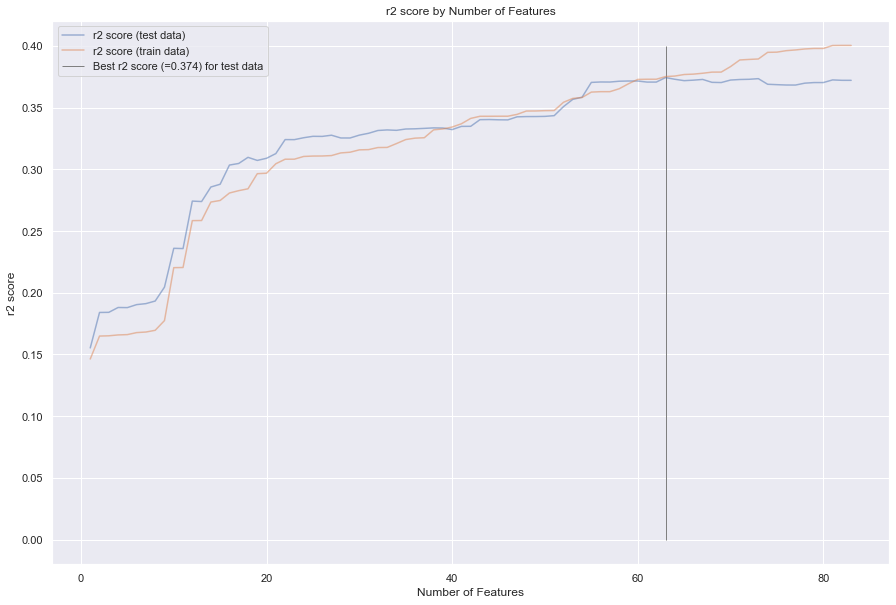

In [8]:
nfeat = best_feat+20

plt.rcParams["figure.figsize"] = [15, 10]
plt.plot(range(1, nfeat+1), r2_scores_test[:nfeat], label="r2 score (test data)", alpha=.5)
plt.plot(range(1, nfeat+1), r2_scores_train[:nfeat], label="r2 score (train data)", alpha=.5)
plt.vlines(x = best_feat, ymin = 0, ymax = 0.4, color = 'grey', linewidth=1, label='Best r2 score (={:.3f}) for test data'.format(test_score))
plt.xlabel('Number of Features')
plt.ylabel('r2 score')
plt.title('r2 score by Number of Features')
plt.legend(loc=2)        
plt.show()

... continuing with feature engineering

___

## Looking closer at relevant features

In [9]:
df_lst_feat = df_list_num.copy()

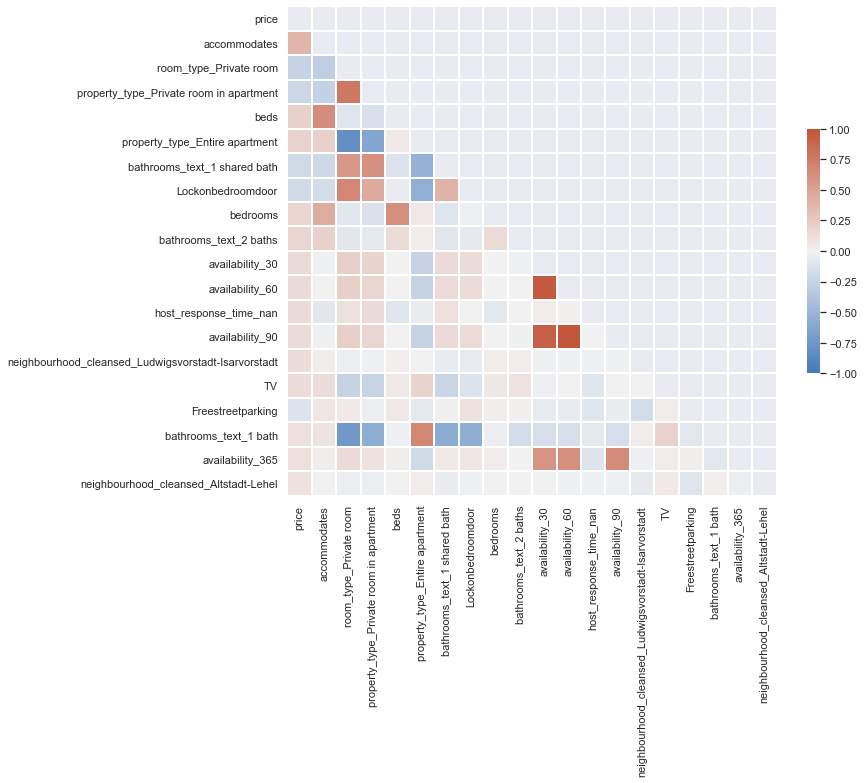

In [10]:
# target is the price
y_target_col = 'price'
# Create a ranking of features correlated (+/-) with the target
relevant_features = np.abs(df_lst_feat.corr()[y_target_col]).sort_values(ascending=False)

#remove columns with NaN relevancy and the target
relevant_features = relevant_features[~relevant_features.isnull()]

# Print heatmap for the first 20 relevant features

corr = df_lst_feat[relevant_features[:20].index].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(250, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5});

In [11]:
relevant_features.drop(index=y_target_col, inplace=True)

### As a next improvement, I'll remove outliers for most correlated features. This should make some improvement to the model.

___

### Let's focus to top 20 features

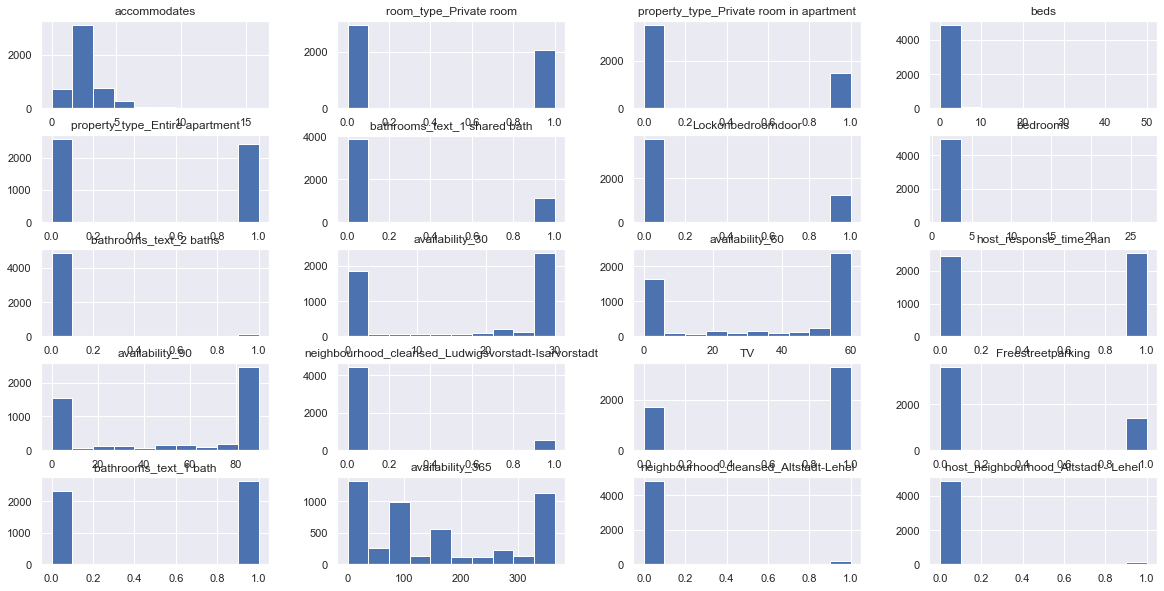

In [12]:
plt.rcParams["figure.figsize"] = [20, 10]
df_lst_feat[relevant_features[:20].index].hist();

### *accomodates, beds, bedrooms* look to have some outliers

___

In [13]:
plt.rcParams["figure.figsize"] = [7, 5]

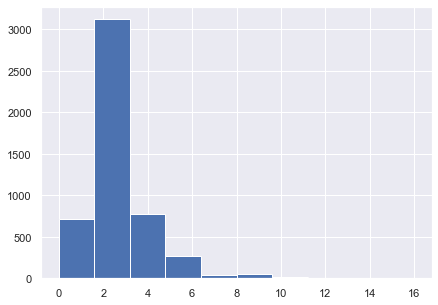

In [14]:
df_lst_feat.accommodates.hist();

Drop rows with accomodates less than 7.

In [15]:
df_lst_feat = df_lst_feat[df_lst_feat.accommodates < 7]

___

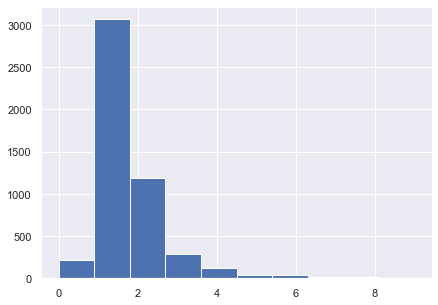

In [16]:
df_list_num[df_list_num.beds < 10].beds.hist();

Drop rows with beds less than 6.

In [17]:
df_lst_feat = df_lst_feat[df_lst_feat.beds < 6]

___

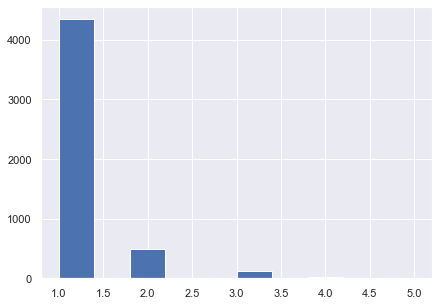

In [18]:
df_list_num[df_list_num.bedrooms < 6].bedrooms.hist();

Drop rows with bedrooms less than 3.

In [19]:
df_lst_feat = df_lst_feat[df_lst_feat.bedrooms < 3]

___

#### Looks better now:

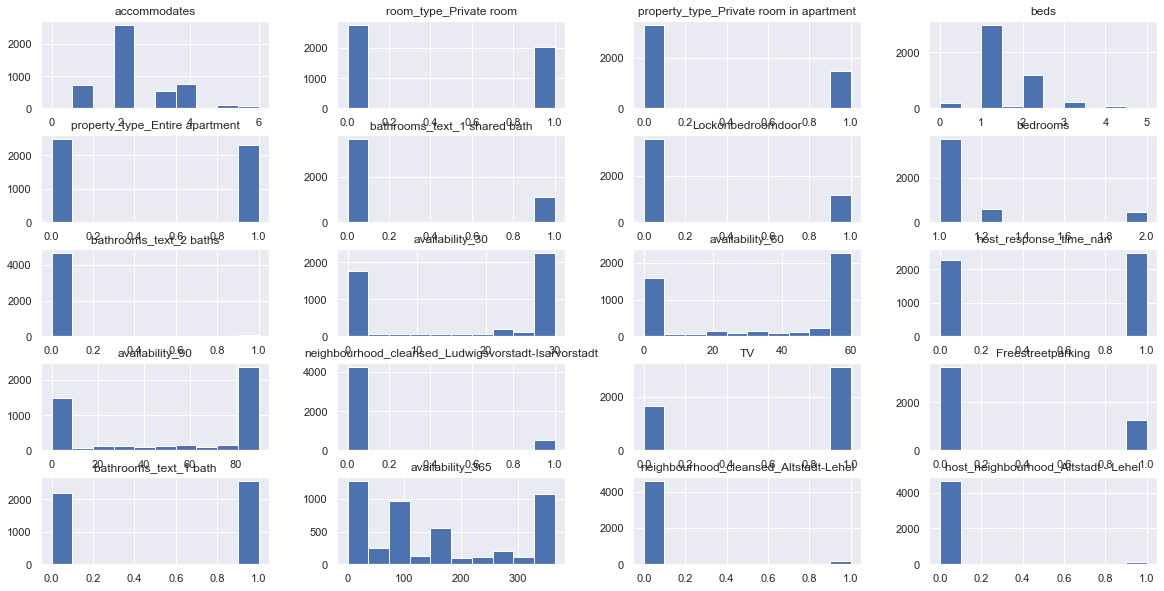

In [20]:
plt.rcParams["figure.figsize"] = [20, 10]
df_lst_feat[relevant_features[:20].index].hist();

### We could continue one column after another but let's have a look first, if this it brings some improvements to the model!

___

### Cut-off more outliers in the **price** column

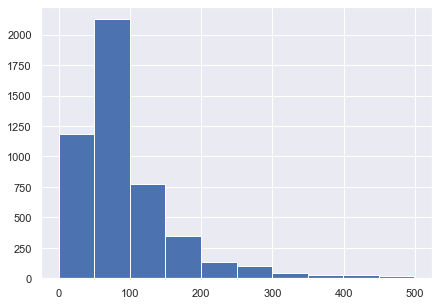

In [21]:
plt.rcParams["figure.figsize"] = [7, 5]
df_lst_feat.price.hist();

Let's try to cut off ever more and reduce the data to prices less than 280.

In [22]:
df_lst_feat = df_lst_feat[df_lst_feat.price < 280]

___

## Running linear regression again

In [23]:
best_feat, r2_scores_train, r2_scores_test, train_score, test_score = find_best_score(
    df=df_lst_feat, 
    relevant=relevant_features, 
    y_target=y_target_col, 
    plot=False, 
    show_score=False, 
    negative_in_row_to_stop=100)

Best model with 160 features: r2_score for training set 0.42 and r2_score for test set 0.39


___

#### Removing just some of the outliers improved the r2 score on training data by +10% (0.38 to 0.42) and on test data by +5% (0.37 to 0.39). This process (figure out relevant features -> remove ourliers -> re-run regression) can continue in a loop to possibly achieve even better r2 score values. 

### Please feel free to take over from here and let me know how far you got with the improvements of the model. 